In [1]:
import pyspark
print("PySpark version:", pyspark.__version__)


PySpark version: 3.4.4


In [2]:
from pyspark.sql import SparkSession
import os

# Dynamically load all .jar files from your folder
jar_path = ",".join([
    os.path.join("C:/jars", jar) 
    for jar in os.listdir("C:/jars") if jar.endswith(".jar")
])

# Create Spark session using the jars
spark = SparkSession.builder \
    .appName("FinalSparkSetup") \
    .config("spark.jars", jar_path) \
    .getOrCreate()


In [3]:
spark.conf.set("fs.azure.account.key.powerliftingdataadls2025.dfs.core.windows.net",
               "YOUR_AZURE_STORAGE_KEY_HERE")


In [4]:
meets_df = spark.read.csv(
    "abfss://datasets@powerliftingdataadls2025.dfs.core.windows.net/meets.csv",
    header=True,
    inferSchema=True
)
meets_df.show(5)


+------+--------------+----------+----------+-----------+---------+---------+--------------------+
|MeetID|      MeetPath|Federation|      Date|MeetCountry|MeetState| MeetTown|            MeetName|
+------+--------------+----------+----------+-----------+---------+---------+--------------------+
|     0|365strong/1601| 365Strong|2016-10-29|        USA|       NC|Charlotte|2016 Junior & Sen...|
|     1|365strong/1602| 365Strong|2016-11-19|        USA|       MO|    Ozark|Thanksgiving Powe...|
|     2|365strong/1603| 365Strong|2016-07-09|        USA|       NC|Charlotte|Charlotte Europa ...|
|     3|365strong/1604| 365Strong|2016-06-11|        USA|       SC|Rock Hill|Carolina Cup Push...|
|     4|365strong/1605| 365Strong|2016-04-10|        USA|       SC|Rock Hill|Eastern USA Chall...|
+------+--------------+----------+----------+-----------+---------+---------+--------------------+
only showing top 5 rows



In [5]:
power_df = spark.read.csv(
    "abfss://datasets@powerliftingdataadls2025.dfs.core.windows.net/openpowerlifting.csv",
    header=True,
    inferSchema=True
)
power_df.show(5)


+------+----------------+---+----------+----+-----------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+------+
|MeetID|            Name|Sex| Equipment| Age|   Division|BodyweightKg|WeightClassKg|Squat4Kg|BestSquatKg|Bench4Kg|BestBenchKg|Deadlift4Kg|BestDeadliftKg|TotalKg|Place| Wilks|
+------+----------------+---+----------+----+-----------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+------+
|     0|Angie Belk Terry|  F|     Wraps|47.0|  Mst 45-49|        59.6|           60|    null|      47.63|    null|      20.41|       null|         70.31| 138.35|    1|155.05|
|     0|     Dawn Bogart|  F|Single-ply|42.0|  Mst 40-44|       58.51|           60|    null|     142.88|    null|      95.25|       null|        163.29| 401.42|    1|456.38|
|     0|     Dawn Bogart|  F|Single-ply|42.0|Open Senior|       58.51|           60|    null|     142.88|    null|      95.25

In [6]:
from pyspark.sql.functions import col, sum, when

# Calculate nulls for each column in power_df
null_counts_power = power_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in power_df.columns
])

null_counts_power.show(truncate=False)


+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+-----+
|MeetID|Name|Sex|Equipment|Age   |Division|BodyweightKg|WeightClassKg|Squat4Kg|BestSquatKg|Bench4Kg|BestBenchKg|Deadlift4Kg|BestDeadliftKg|TotalKg|Place|Wilks|
+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+-----+
|0     |0   |0  |0        |239267|15843   |2402        |3812         |385171  |88343      |384452  |30050      |383614     |68567         |23177  |1092 |24220|
+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+-----+



In [7]:
# Calculate nulls for each column in meets_df
null_counts_meets = meets_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in meets_df.columns
])

null_counts_meets.show(truncate=False)


+------+--------+----------+----+-----------+---------+--------+--------+
|MeetID|MeetPath|Federation|Date|MeetCountry|MeetState|MeetTown|MeetName|
+------+--------+----------+----+-----------+---------+--------+--------+
|0     |0       |0         |0   |0          |2986     |1509    |0       |
+------+--------+----------+----+-----------+---------+--------+--------+



In [8]:
power_row_count = power_df.count()
print(f"Total rows in power_df (performance data): {power_row_count}")


Total rows in power_df (performance data): 386414


In [9]:
from pyspark.sql.functions import col

rows_before = power_df.count()

power_df_clean = power_df.dropna(subset=["TotalKg", "Wilks", "Sex", "Equipment", "BodyweightKg", "MeetID"])

rows_after = power_df_clean.count()

rows_dropped = rows_before - rows_after
print(f"Rows dropped: {rows_dropped}")

Rows dropped: 24220


In [10]:
meets_row_count = meets_df.count()
print(f"Total rows in meets_df (meet details): {meets_row_count}")


Total rows in meets_df (meet details): 8482


In [11]:
from pyspark.sql.functions import col

rows_before_meets = meets_df.count()

# Drop rows where any of these critical columns are null
meets_cleaned = meets_df.dropna(subset=["Federation", "Date", "MeetID"])

rows_after_meets = meets_cleaned.count()

rows_dropped_meets = rows_before_meets - rows_after_meets
print(f"Rows dropped from meets_df: {rows_dropped_meets}")

Rows dropped from meets_df: 0


In [12]:
joined_df = power_df_clean.join(meets_cleaned, on="MeetID", how="inner")
joined_row_count = joined_df.count()
print(f"Total rows after join: {joined_row_count}")


Total rows after join: 362194


# EDA

In [14]:
joined_df.printSchema()
joined_df.show(5)


root
 |-- MeetID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Equipment: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Division: string (nullable = true)
 |-- BodyweightKg: double (nullable = true)
 |-- WeightClassKg: string (nullable = true)
 |-- Squat4Kg: double (nullable = true)
 |-- BestSquatKg: double (nullable = true)
 |-- Bench4Kg: double (nullable = true)
 |-- BestBenchKg: double (nullable = true)
 |-- Deadlift4Kg: double (nullable = true)
 |-- BestDeadliftKg: double (nullable = true)
 |-- TotalKg: double (nullable = true)
 |-- Place: string (nullable = true)
 |-- Wilks: double (nullable = true)
 |-- MeetPath: string (nullable = true)
 |-- Federation: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- MeetCountry: string (nullable = true)
 |-- MeetState: string (nullable = true)
 |-- MeetTown: string (nullable = true)
 |-- MeetName: string (nullable = true)

+------+----------------+---+--

In [15]:
from pyspark.sql.functions import sum, when, col

null_check = joined_df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in joined_df.columns
])
null_check.show()


+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+-----+--------+----------+----+-----------+---------+--------+--------+
|MeetID|Name|Sex|Equipment|   Age|Division|BodyweightKg|WeightClassKg|Squat4Kg|BestSquatKg|Bench4Kg|BestBenchKg|Deadlift4Kg|BestDeadliftKg|TotalKg|Place|Wilks|MeetPath|Federation|Date|MeetCountry|MeetState|MeetTown|MeetName|
+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+-----------+-----------+--------------+-------+-----+-----+--------+----------+----+-----------+---------+--------+--------+
|     0|   0|  0|        0|223262|   14422|           0|         2119|  360854|      74952|  360137|      14209|     359306|         51827|      0| 1060|    0|       0|         0|   0|          0|    72582|   88998|       0|
+------+----+---+---------+------+--------+------------+-------------+--------+-----------+--------+

In [16]:
joined_df.describe(["TotalKg", "Wilks", "BodyweightKg", "Age"]).show()


+-------+------------------+------------------+-----------------+------------------+
|summary|           TotalKg|             Wilks|     BodyweightKg|               Age|
+-------+------------------+------------------+-----------------+------------------+
|  count|            362194|            362194|           362194|            139195|
|   mean|423.90821291904035|301.08060061997224| 86.7296377604266| 31.62031682172492|
| stddev| 195.9769300616651|116.36039626071847|23.05064960990501|12.922482243077168|
|    min|              11.0|             13.73|            15.88|               5.0|
|    max|           1365.31|            779.38|            242.4|              95.0|
+-------+------------------+------------------+-----------------+------------------+



In [17]:
joined_df.groupBy("Sex").count().show()


+---+------+
|Sex| count|
+---+------+
|  F| 84182|
|  M|278012|
+---+------+



In [18]:
joined_df.groupBy("Equipment").count().orderBy("count", ascending=False).show()


+----------+------+
| Equipment| count|
+----------+------+
|       Raw|179642|
|Single-ply|130021|
|     Wraps| 44190|
| Multi-ply|  8334|
|    Straps|     7|
+----------+------+



In [19]:
joined_df.groupBy("Federation").count().orderBy("count", ascending=False).show(10)


+----------+-----+
|Federation|count|
+----------+-----+
|     USAPL|72969|
|      USPA|53728|
|     THSPA|52661|
|       NSF|28964|
|       CPU|28222|
|       RPS|22647|
|       SPF|17478|
|        PA|12099|
|      NASA| 8814|
|       IPF| 8605|
+----------+-----+
only showing top 10 rows



In [20]:
sample_df = joined_df.sample(False, 0.1, seed=42).toPandas()


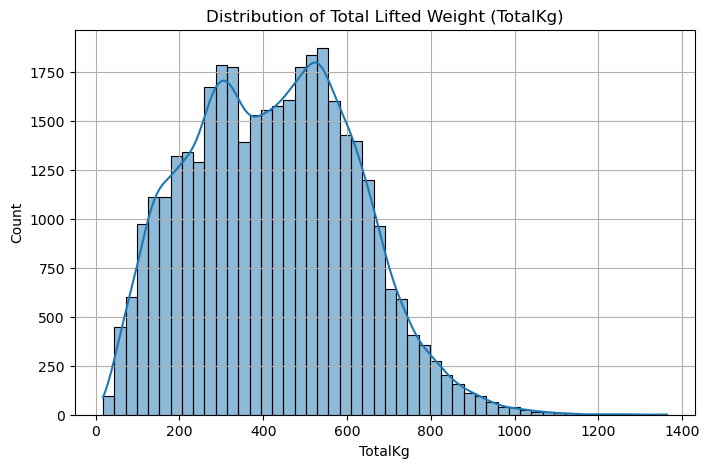

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(sample_df["TotalKg"], bins=50, kde=True)
plt.title("Distribution of Total Lifted Weight (TotalKg)")
plt.grid(True)
plt.show()


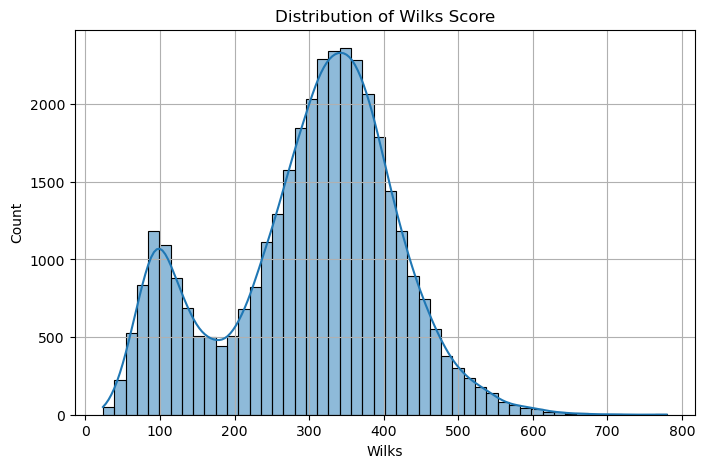

In [22]:
plt.figure(figsize=(8, 5))
sns.histplot(sample_df["Wilks"], bins=50, kde=True)
plt.title("Distribution of Wilks Score")
plt.grid(True)
plt.show()


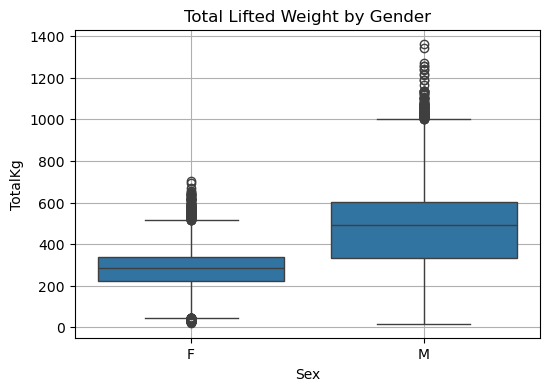

In [23]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=sample_df, x="Sex", y="TotalKg")
plt.title("Total Lifted Weight by Gender")
plt.grid(True)
plt.show()


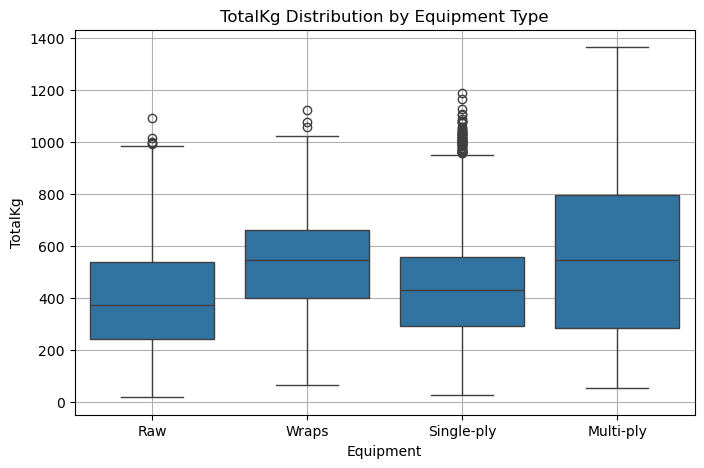

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=sample_df, x="Equipment", y="TotalKg")
plt.title("TotalKg Distribution by Equipment Type")
plt.grid(True)
plt.show()


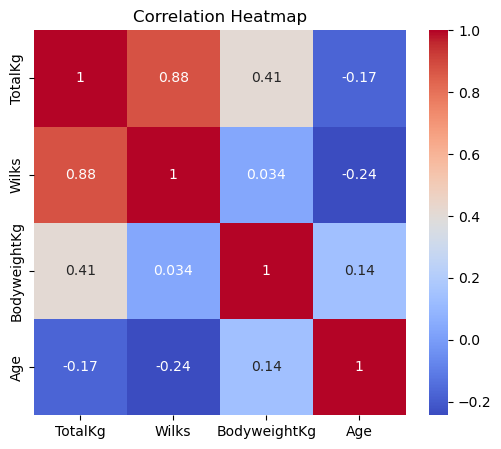

In [25]:
plt.figure(figsize=(6, 5))
sns.heatmap(sample_df[["TotalKg", "Wilks", "BodyweightKg", "Age"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


# RESEARCH QUESTION 1 

## 1. RQ: How has the performance (TotalKg and Wilks Score) of lifters evolved over the years across different federations?

In [28]:
from pyspark.sql.functions import year, to_date

# Ensure date is in proper format, then extract year
joined_df = joined_df.withColumn("Year", year(to_date("Date", "yyyy-MM-dd")))


In [29]:
from pyspark.sql.functions import avg

trend_df = joined_df.groupBy("Year", "Federation").agg(
    avg("TotalKg").alias("Avg_TotalKg"),
    avg("Wilks").alias("Avg_Wilks")
).orderBy("Year", "Federation")

trend_df.show(10)


+----+----------+------------------+------------------+
|Year|Federation|       Avg_TotalKg|         Avg_Wilks|
+----+----------+------------------+------------------+
|1974|       IPF| 620.4435483870968|450.36532258064517|
|1974|       NSF|459.07509157509156| 324.4053479853479|
|1975|       IPF| 593.3695652173913| 425.5217391304348|
|1975|       NSF| 440.9959349593496| 311.2334146341463|
|1976|       IPF| 616.2686567164179| 444.3135820895522|
|1977|       IPF| 622.2222222222222| 460.1350793650794|
|1978|       IPF| 663.7951807228916| 463.8803614457832|
|1978|       NSF| 584.6428571428571| 406.3885714285715|
|1979|       CPU| 597.9787234042553| 433.8131914893618|
|1979|       IPF| 638.7362637362637| 461.9264835164836|
+----+----------+------------------+------------------+
only showing top 10 rows



In [30]:
top_federations = (
    joined_df.groupBy("Federation")
    .count()
    .orderBy("count", ascending=False)
    .limit(5)
    .toPandas()["Federation"]
    .tolist()
)


In [31]:
filtered_trend_df = trend_df.filter(col("Federation").isin(top_federations))

In [32]:
trend_pd = filtered_trend_df.toPandas()


C:\Users\KRISHNAVENI\AppData\Local\Temp\ipykernel_18952\4025660294.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\KRISHNAVENI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


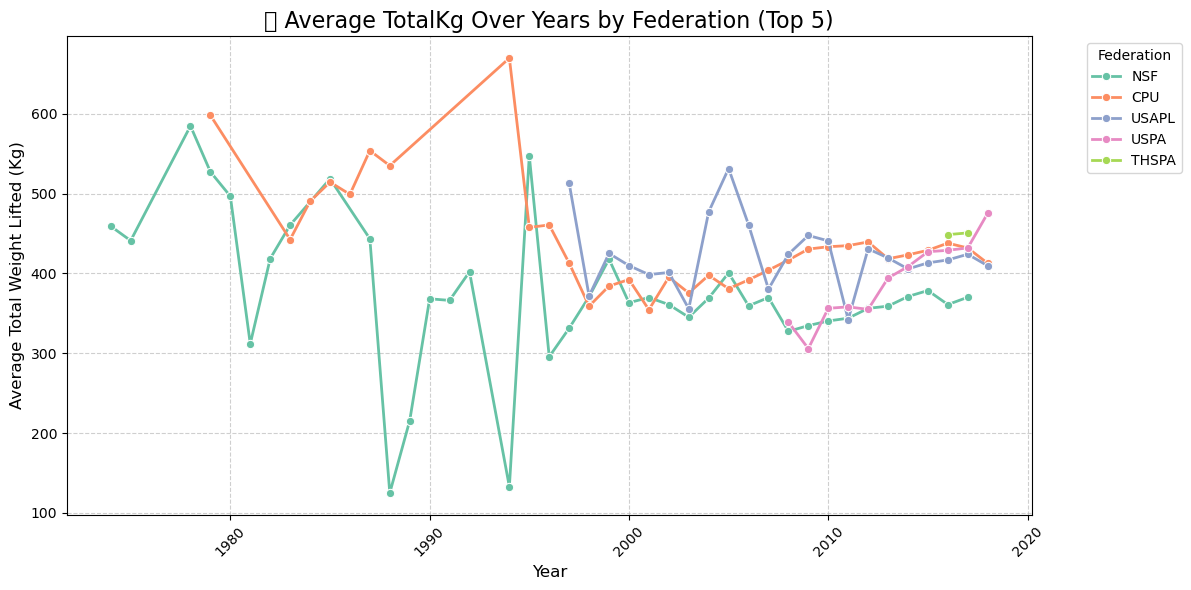

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend_pd,
    x="Year",
    y="Avg_TotalKg",
    hue="Federation",
    marker="o",
    palette="Set2",
    linewidth=2
)

plt.title("📊 Average TotalKg Over Years by Federation (Top 5)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Total Weight Lifted (Kg)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Federation", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\KRISHNAVENI\AppData\Local\Temp\ipykernel_18952\618080763.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\KRISHNAVENI\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


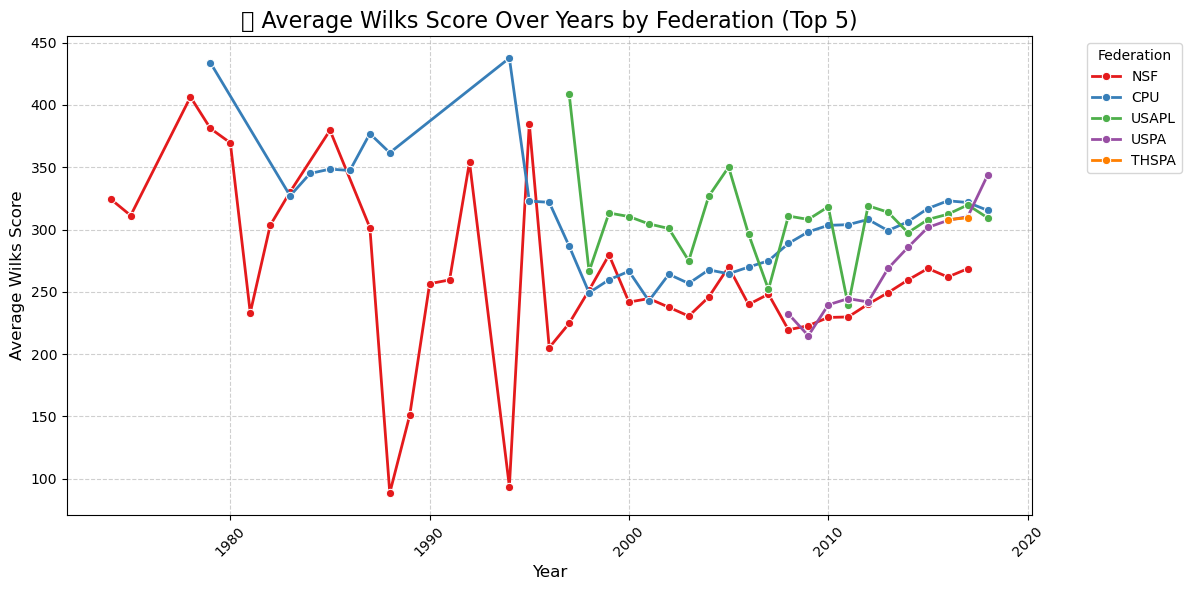

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend_pd,
    x="Year",
    y="Avg_Wilks",
    hue="Federation",
    marker="o",
    palette="Set1",
    linewidth=2
)

plt.title("📈 Average Wilks Score Over Years by Federation (Top 5)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Wilks Score", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Federation", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [35]:
from pyspark.sql.functions import year, avg

# Extract year from Date
trend_weight_wilks_df = (
    joined_df.withColumn("Year", year("Date"))
    .groupBy("Year")
    .agg(
        avg("Wilks").alias("Avg_Wilks"),
        avg("BodyweightKg").alias("Avg_Bodyweight")
    )
    .orderBy("Year")
)

trend_weight_wilks_df.show()


+----+------------------+-----------------+
|Year|         Avg_Wilks|   Avg_Bodyweight|
+----+------------------+-----------------+
|1974|347.71734328358184|76.67552238805966|
|1975|352.30578124999994|77.84479166666664|
|1976| 444.3135820895522|             77.0|
|1977| 460.1350793650794|74.08730158730158|
|1978| 455.5825773195877|80.31752577319588|
|1979|  444.716847826087|76.61413043478262|
|1980| 464.0969230769233|79.80804195804193|
|1981|431.18758620689636|81.52068965517239|
|1982|359.25822916666647|78.44999999999995|
|1983| 410.9041704035874|82.15336322869953|
|1984| 427.9731007751936|83.67054263565896|
|1985|418.29039525691707|83.40711462450591|
|1986| 421.9798480243161|83.64255319148937|
|1987|413.63723300970867| 83.4140776699029|
|1988|202.21643243243238|80.82162162162163|
|1989|218.47260606060613|78.53454545454545|
|1990|256.52149321266984|79.75746606334845|
|1991|  264.359090309822|78.90758075148312|
|1992|460.07395833333317| 83.7739583333333|
|1993| 209.1440229885057|79.4252

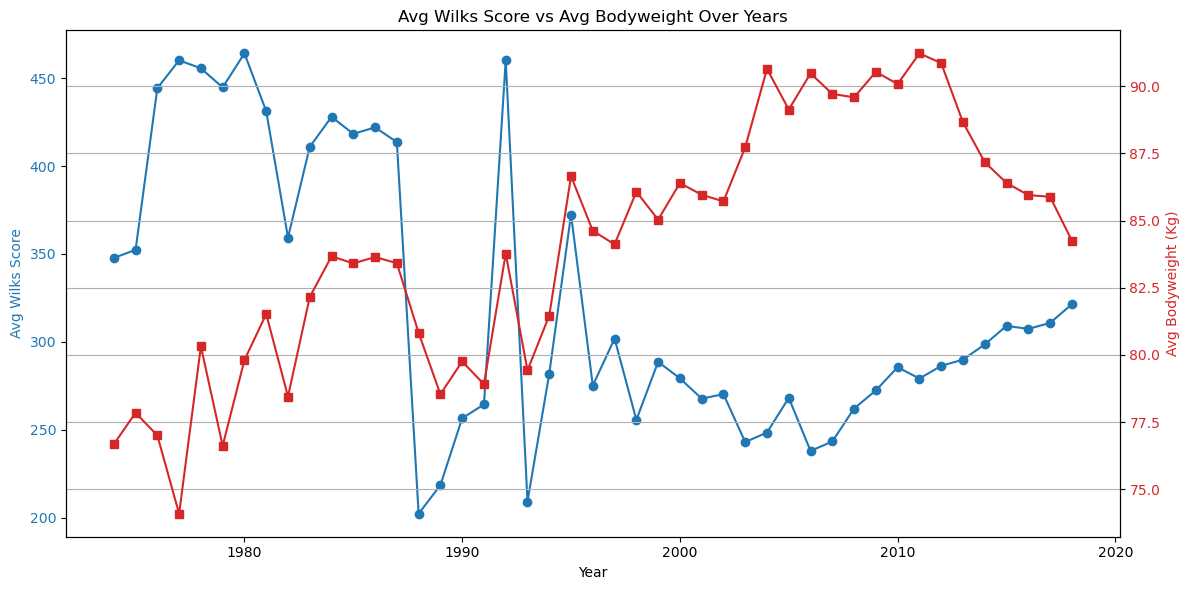

In [36]:
# Convert to Pandas
trend_weight_wilks_pd = trend_weight_wilks_df.toPandas()

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Avg Wilks Score
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Wilks Score', color=color)
ax1.plot(trend_weight_wilks_pd["Year"], trend_weight_wilks_pd["Avg_Wilks"], color=color, marker='o', label='Avg Wilks')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Bodyweight
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Bodyweight (Kg)', color=color)
ax2.plot(trend_weight_wilks_pd["Year"], trend_weight_wilks_pd["Avg_Bodyweight"], color=color, marker='s', label='Avg Bodyweight')
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title("Avg Wilks Score vs Avg Bodyweight Over Years")
fig.tight_layout()
plt.grid(True)
plt.show()


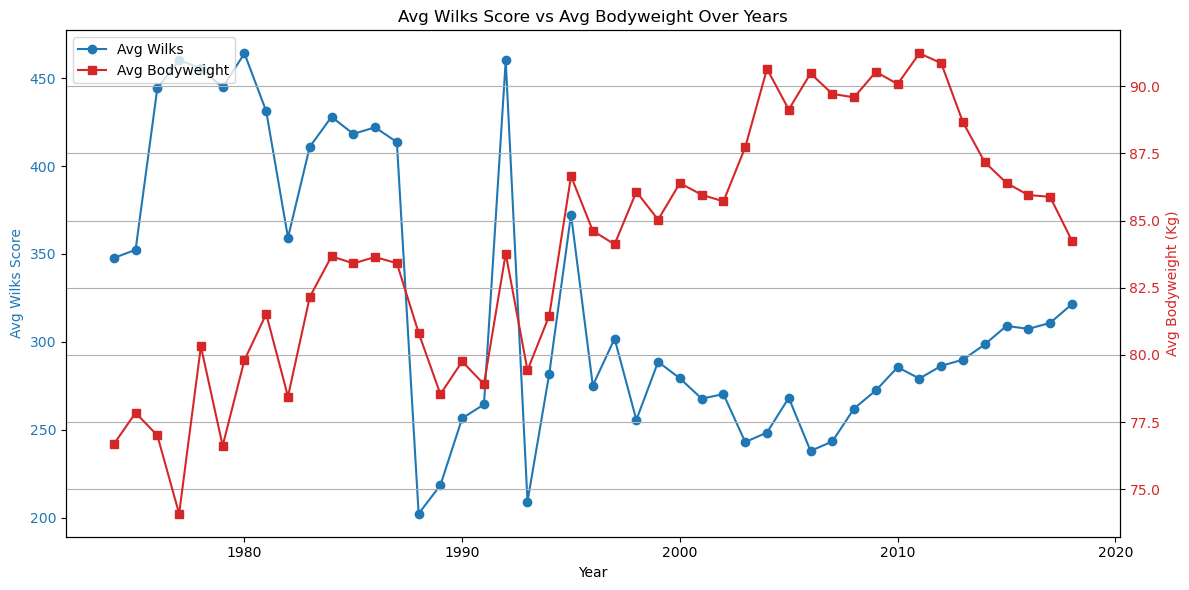

In [37]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Avg Wilks Score
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Wilks Score', color=color)
line1, = ax1.plot(trend_weight_wilks_pd["Year"], trend_weight_wilks_pd["Avg_Wilks"],
                  color=color, marker='o', label='Avg Wilks')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for Bodyweight
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Avg Bodyweight (Kg)', color=color)
line2, = ax2.plot(trend_weight_wilks_pd["Year"], trend_weight_wilks_pd["Avg_Bodyweight"],
                  color=color, marker='s', label='Avg Bodyweight')
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title("Avg Wilks Score vs Avg Bodyweight Over Years")
fig.tight_layout()
plt.grid(True)

# Add legend manually (from both axes)
lines = [line1, line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc="upper left")

plt.show()


## RQ2: What is the performance impact of different lifting equipment types across genders?


In [39]:
from pyspark.sql.functions import avg

equipment_gender_df = joined_df.groupBy("Equipment", "Sex").agg(
    avg("TotalKg").alias("Avg_TotalKg"),
    avg("Wilks").alias("Avg_Wilks")
).orderBy("Equipment", "Sex")

equipment_gender_df.show()


+----------+---+-----------------+------------------+
| Equipment|Sex|      Avg_TotalKg|         Avg_Wilks|
+----------+---+-----------------+------------------+
| Multi-ply|  F| 375.566523400191| 375.6229302769819|
| Multi-ply|  M| 592.520920817895| 360.7317118361469|
|       Raw|  F|262.8884382772383| 271.4513897883238|
|       Raw|  M|  443.47482332027|288.31574077007036|
|Single-ply|  F|291.3309394533643|307.00933437308555|
|Single-ply|  M|447.6325608822973| 299.0905774711318|
|    Straps|  M|388.2142857142857|229.35428571428568|
|     Wraps|  F|323.0102552607501|327.03472868252504|
|     Wraps|  M|603.3522949488904|378.32742741130454|
+----------+---+-----------------+------------------+



In [40]:
equipment_gender_pd = equipment_gender_df.toPandas()


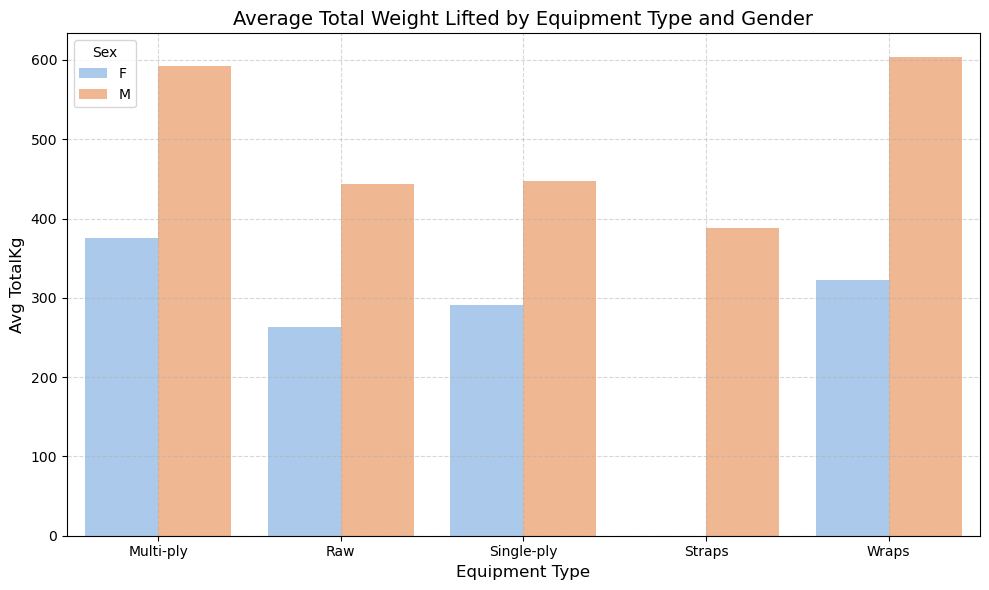

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(
    data=equipment_gender_pd,
    x="Equipment",
    y="Avg_TotalKg",
    hue="Sex",
    palette="pastel"
)
plt.title("Average Total Weight Lifted by Equipment Type and Gender", fontsize=14)
plt.xlabel("Equipment Type", fontsize=12)
plt.ylabel("Avg TotalKg", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


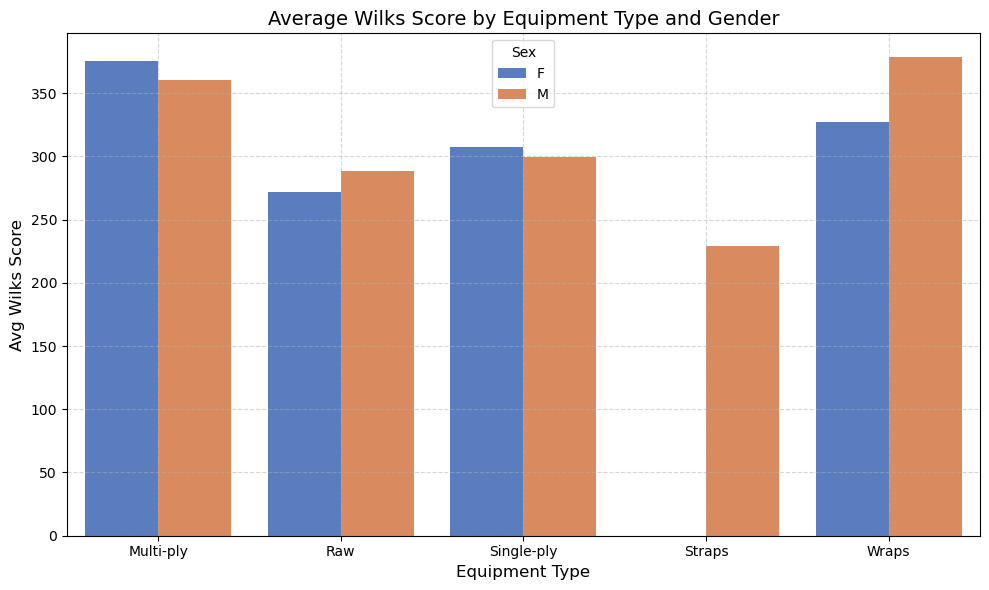

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=equipment_gender_pd,
    x="Equipment",
    y="Avg_Wilks",
    hue="Sex",
    palette="muted"
)
plt.title("Average Wilks Score by Equipment Type and Gender", fontsize=14)
plt.xlabel("Equipment Type", fontsize=12)
plt.ylabel("Avg Wilks Score", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


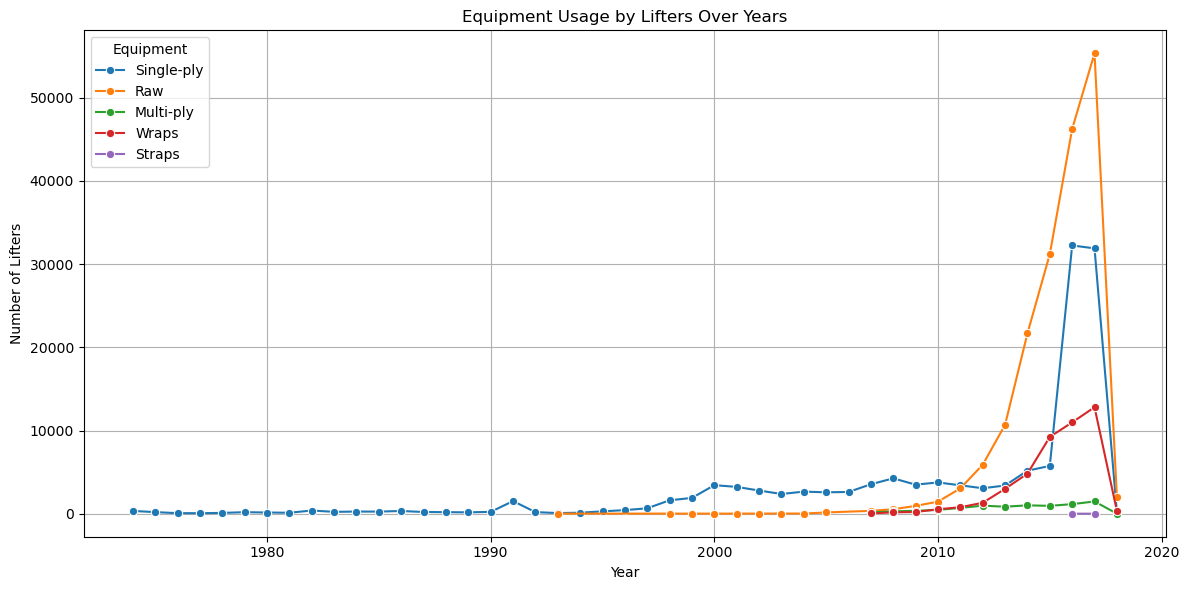

In [43]:
from pyspark.sql.functions import year, count

# Extract year from date
equipment_trend_df = joined_df.withColumn("Year", year("Date")) \
    .groupBy("Year", "Equipment") \
    .agg(count("*").alias("LifterCount")) \
    .orderBy("Year", "Equipment")

# Convert to pandas for plotting
equipment_trend_pd = equipment_trend_df.toPandas()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=equipment_trend_pd, x="Year", y="LifterCount", hue="Equipment", marker="o")
plt.title("Equipment Usage by Lifters Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Lifters")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\KRISHNAVENI\AppData\Local\Temp\ipykernel_18952\785703068.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=equipment_perf_pd, x="Equipment", y="Avg_TotalKg", palette="muted")


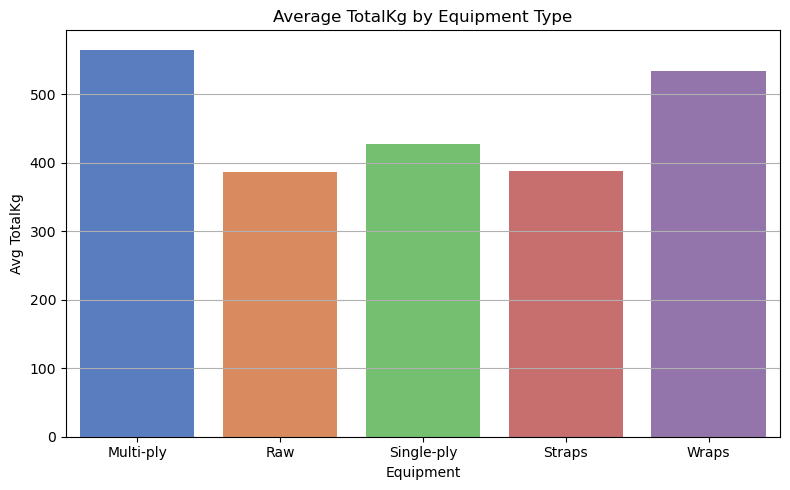

C:\Users\KRISHNAVENI\AppData\Local\Temp\ipykernel_18952\785703068.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=equipment_perf_pd, x="Equipment", y="Avg_Wilks", palette="pastel")


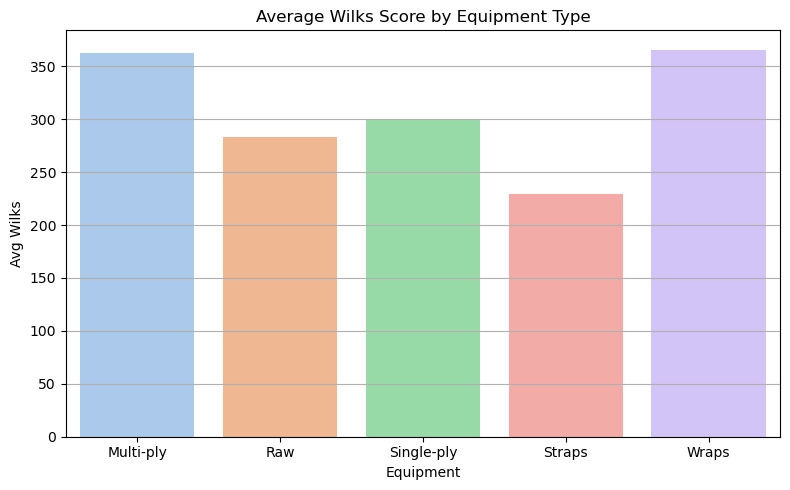

In [44]:
from pyspark.sql.functions import avg

equipment_perf_df = joined_df.groupBy("Equipment").agg(
    avg("TotalKg").alias("Avg_TotalKg"),
    avg("Wilks").alias("Avg_Wilks")
).orderBy("Equipment")

equipment_perf_pd = equipment_perf_df.toPandas()

# Plot: Avg TotalKg
plt.figure(figsize=(8, 5))
sns.barplot(data=equipment_perf_pd, x="Equipment", y="Avg_TotalKg", palette="muted")
plt.title("Average TotalKg by Equipment Type")
plt.xlabel("Equipment")
plt.ylabel("Avg TotalKg")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Plot: Avg Wilks
plt.figure(figsize=(8, 5))
sns.barplot(data=equipment_perf_pd, x="Equipment", y="Avg_Wilks", palette="pastel")
plt.title("Average Wilks Score by Equipment Type")
plt.xlabel("Equipment")
plt.ylabel("Avg Wilks")
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


## RQ3: Is there a significant difference in performance across weight classes, and how does bodyweight correlate with Wilks score?

In [46]:
joined_df.groupBy("WeightClassKg").count().orderBy("WeightClassKg").show(30)


+-------------+-----+
|WeightClassKg|count|
+-------------+-----+
|         null| 2249|
|          100|31991|
|         100+|   27|
|          105|13145|
|          110|25704|
|         110+|  138|
|        117.5|  727|
|          120| 8132|
|         120+| 5399|
|          125|20232|
|         125+| 5092|
|          140| 5826|
|         140+| 3937|
|          145|   18|
|          155|    1|
|           30|   43|
|           34|    1|
|           35|   65|
|           39|    2|
|           40|   76|
|           43|  201|
|           44|  685|
|           47| 1274|
|           48| 1418|
|           52| 9108|
|           53|  411|
|           56| 8553|
|           57| 5275|
|           59| 2242|
|           60|12710|
+-------------+-----+
only showing top 30 rows



In [47]:
from pyspark.sql.functions import avg

weightclass_perf_df = joined_df.groupBy("WeightClassKg").agg(
    avg("TotalKg").alias("Avg_TotalKg"),
    avg("Wilks").alias("Avg_Wilks"),
    avg("BodyweightKg").alias("Avg_Bodyweight")
).orderBy("WeightClassKg")

weightclass_perf_df.show(20)


+-------------+------------------+------------------+------------------+
|WeightClassKg|       Avg_TotalKg|         Avg_Wilks|    Avg_Bodyweight|
+-------------+------------------+------------------+------------------+
|         null| 468.8830502445529|333.00834593152535| 88.96536238328149|
|          100|485.32219593010535|  300.056561793942| 96.86414847925958|
|         100+| 541.4781481481481|324.68148148148146|112.69148148148149|
|          105| 527.6864739444655| 320.0499617344997|100.90296614682381|
|          110|506.36492530345447| 301.3976538009648|106.58952769996894|
|         110+| 685.5902173913043| 394.1815217391304| 130.3377536231884|
|        117.5| 504.6889683631365| 293.4806052269601|115.75808803301241|
|          120| 546.3389818002951| 318.1875946876535|114.13880226266589|
|         120+| 559.6506204852751| 313.9694417484721|137.98607242081866|
|          125| 524.4110928232496|302.07252792111507| 119.1803949189402|
|         125+| 547.4036488609578| 306.535686174390

C:\Users\KRISHNAVENI\AppData\Local\Temp\ipykernel_18952\109608917.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = weightclass_pd_clean.groupby("Weight_Bin").agg({


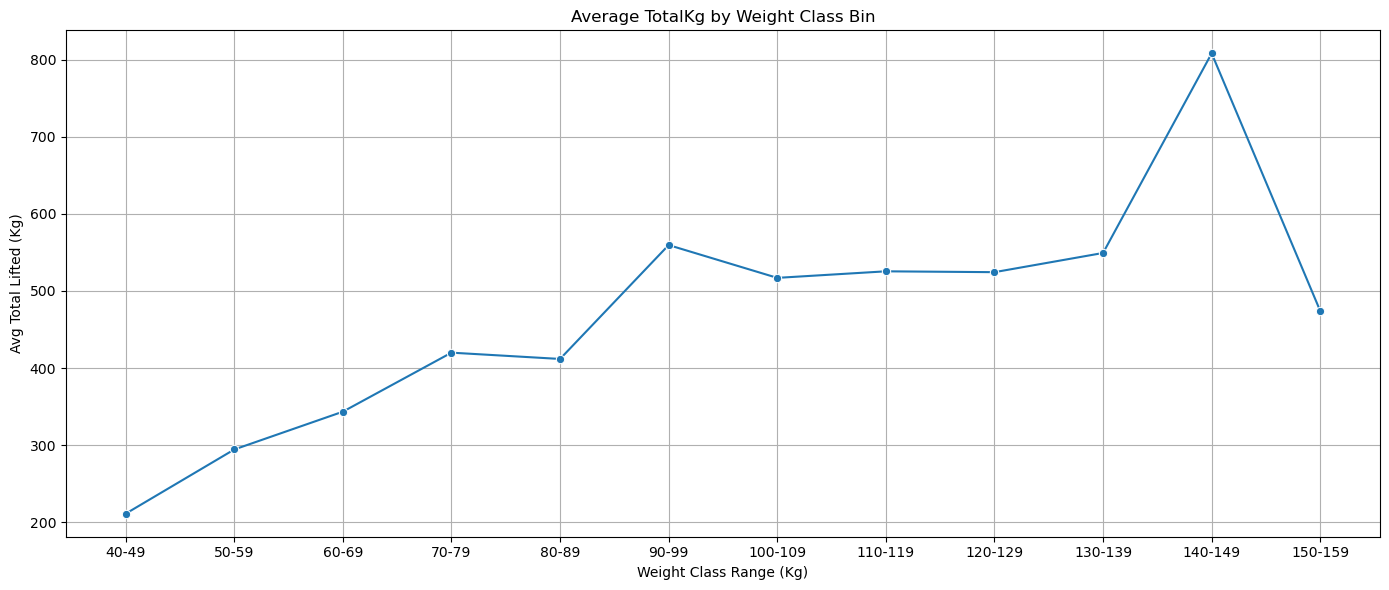

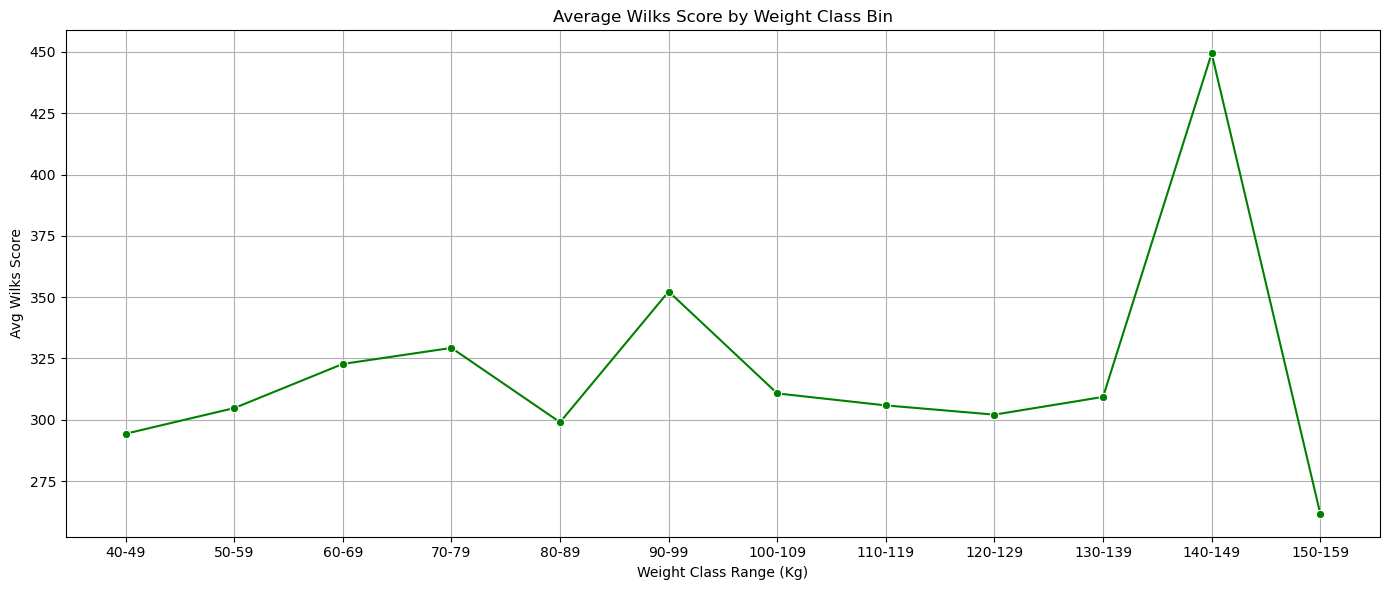

In [51]:
# Convert Spark DataFrame to Pandas safely
weightclass_pd = weightclass_perf_df.toPandas()

# --- Clean & transform in Pandas ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Drop NaNs and convert to numeric
weightclass_pd_clean = weightclass_pd.dropna(subset=["WeightClassKg"]).copy()
weightclass_pd_clean["WeightClassKg"] = pd.to_numeric(weightclass_pd_clean["WeightClassKg"], errors="coerce")
weightclass_pd_clean = weightclass_pd_clean.dropna(subset=["WeightClassKg"])

# Bin setup
bins = list(range(40, 181, 10))  # 40–50, 50–60, ..., 170–180
labels = [f"{b}-{b+9}" for b in bins[:-1]]

# Apply binning
weightclass_pd_clean["Weight_Bin"] = pd.cut(weightclass_pd_clean["WeightClassKg"], bins=bins, labels=labels)

# Group by bins and average values
binned_df = weightclass_pd_clean.groupby("Weight_Bin").agg({
    "Avg_TotalKg": "mean",
    "Avg_Wilks": "mean"
}).reset_index()

# --- Plot 1: Avg Total Lifted ---
plt.figure(figsize=(14, 6))
sns.lineplot(data=binned_df, x="Weight_Bin", y="Avg_TotalKg", marker="o")
plt.title("Average TotalKg by Weight Class Bin")
plt.xlabel("Weight Class Range (Kg)")
plt.ylabel("Avg Total Lifted (Kg)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Avg Wilks Score ---
plt.figure(figsize=(14, 6))
sns.lineplot(data=binned_df, x="Weight_Bin", y="Avg_Wilks", marker="o", color="green")
plt.title("Average Wilks Score by Weight Class Bin")
plt.xlabel("Weight Class Range (Kg)")
plt.ylabel("Avg Wilks Score")
plt.grid(True)
plt.tight_layout()
plt.show()


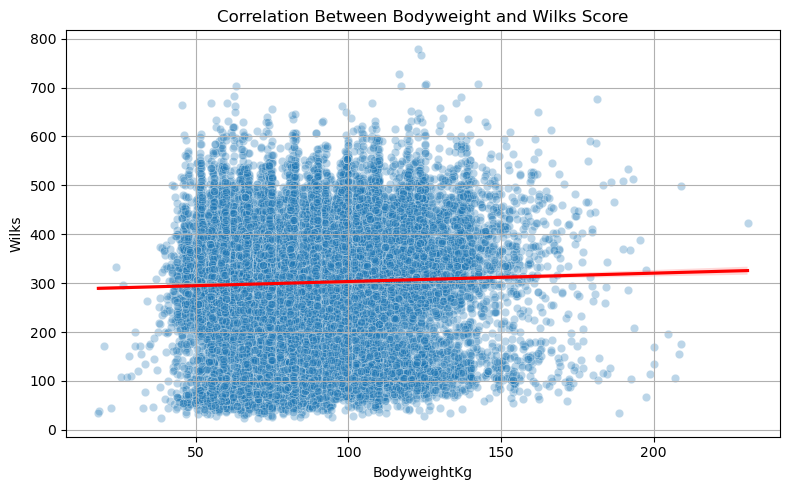

In [53]:
sample_df = joined_df.select("BodyweightKg", "Wilks").dropna().sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(8, 5))
sns.scatterplot(data=sample_df, x="BodyweightKg", y="Wilks", alpha=0.3)
sns.regplot(data=sample_df, x="BodyweightKg", y="Wilks", scatter=False, color='red')
plt.title("Correlation Between Bodyweight and Wilks Score")
plt.grid(True)
plt.tight_layout()
plt.show()


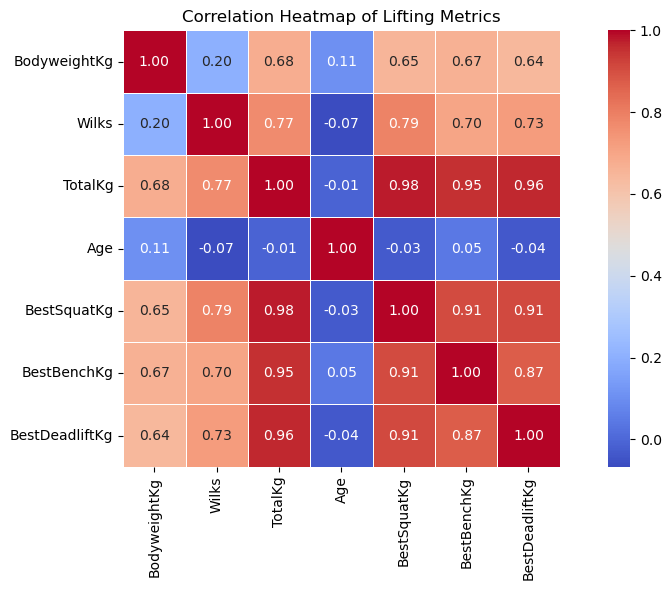

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sample and convert relevant numeric columns to pandas
corr_df = joined_df.select("BodyweightKg", "Wilks", "TotalKg", "Age", "BestSquatKg", "BestBenchKg", "BestDeadliftKg") \
    .dropna().sample(False, 0.1, seed=42).toPandas()

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Heatmap of Lifting Metrics")
plt.tight_layout()
plt.show()


In [59]:
from pyspark.sql import SparkSession

# JDBC connection details
jdbc_url = (
    "jdbc:sqlserver://powerliftserver.database.windows.net:1433;"
    "database=powerliftingdb;"
    "encrypt=true;"
    "trustServerCertificate=false;"
    "hostNameInCertificate=*.database.windows.net;"
    "loginTimeout=30;"
)

connection_properties = {
    "user": "poweradmin@powerliftserver",
    "password": "YOUR_SQL_PASSWORD_HERE",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}


# Convert binned_df (Pandas) to Spark before export
binned_spark_df = spark.createDataFrame(binned_df)

# All export targets
dfs_to_export = {
    "PerformanceTrend": trend_df,
    "CleanedLiftingData": joined_df,
    "WeightClassSummary": weightclass_perf_df,
    "WeightBinWilksTotal": binned_spark_df
}

# Export all to Azure SQL
for table_name, df in dfs_to_export.items():
    print(f"⬆️ Exporting {table_name}...")
    df.write.jdbc(
        url=jdbc_url,
        table=table_name,
        mode="overwrite",  # Use "append" if you don't want to replace
        properties=connection_properties
    )
    print(f"✅ Successfully exported: {table_name}")


⬆️ Exporting PerformanceTrend...
✅ Successfully exported: PerformanceTrend
⬆️ Exporting CleanedLiftingData...
✅ Successfully exported: CleanedLiftingData
⬆️ Exporting WeightClassSummary...
✅ Successfully exported: WeightClassSummary
⬆️ Exporting WeightBinWilksTotal...


Py4JJavaError: An error occurred while calling o667.jdbc.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 160.0 failed 1 times, most recent failure: Lost task 10.0 in stage 160.0 (TID 321) (LAPTOP-VO463JRG executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark-3.4.4-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 683, in main
RuntimeError: Python in worker has different version 3.10 than that in driver 3.12, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.isEmpty(Iterator.scala:387)
	at scala.collection.Iterator.isEmpty$(Iterator.scala:387)
	at scala.collection.AbstractIterator.isEmpty(Iterator.scala:1431)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:676)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:896)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:895)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1012)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1012)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1211)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2989)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2258)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2279)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2298)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2323)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$1(RDD.scala:1012)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:408)
	at org.apache.spark.rdd.RDD.foreachPartition(RDD.scala:1010)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.saveTable(JdbcUtils.scala:895)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:82)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:47)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:75)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:73)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:84)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:247)
	at org.apache.spark.sql.DataFrameWriter.jdbc(DataFrameWriter.scala:753)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\spark\spark-3.4.4-bin-hadoop3\python\lib\pyspark.zip\pyspark\worker.py", line 683, in main
RuntimeError: Python in worker has different version 3.10 than that in driver 3.12, PySpark cannot run with different minor versions. Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.isEmpty(Iterator.scala:387)
	at scala.collection.Iterator.isEmpty$(Iterator.scala:387)
	at scala.collection.AbstractIterator.isEmpty(Iterator.scala:1431)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.savePartition(JdbcUtils.scala:676)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1(JdbcUtils.scala:896)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcUtils$.$anonfun$saveTable$1$adapted(JdbcUtils.scala:895)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2(RDD.scala:1012)
	at org.apache.spark.rdd.RDD.$anonfun$foreachPartition$2$adapted(RDD.scala:1012)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2298)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more


In [61]:
df_check = spark.read.jdbc(
    url=jdbc_url,
    table="PerformanceTrend",
    properties=connection_properties
)

df_check.show(5)


+----+----------+------------------+------------------+
|Year|Federation|       Avg_TotalKg|         Avg_Wilks|
+----+----------+------------------+------------------+
|1974|       IPF| 620.4435483870968|450.36532258064517|
|1974|       NSF|459.07509157509156| 324.4053479853479|
|1975|       IPF| 593.3695652173913| 425.5217391304348|
|1975|       NSF| 440.9959349593496| 311.2334146341463|
|1976|       IPF| 616.2686567164179| 444.3135820895522|
+----+----------+------------------+------------------+
only showing top 5 rows

